# Projet HumanForYou : Prédiction de l'Attrition des Employés

Ce notebook présente l'intégralité du pipeline de Machine Learning pour prédire quels employés sont susceptibles de quitter l'entreprise.
Nous allons :
1. Charger les données nettoyées et normalisées.
2. Analyser les facteurs d'influence (pourquoi ils partent/restent).
3. Entraîner 9 modèles différents (dont XGBoost et Réseau de Neurones).
4. Comparer les performances (Recall, F1-Score).
5. Visualiser les erreurs et l'importance des variables.

Initialisation des données

In [1]:
import pandas as pd #Lire les fichiers CSV
import matplotlib.pyplot as plt
import seaborn as sns #Visualisation des donnees
import time

# Imports des differentes IA pour le Machine Learning
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix
# Configuration de seaborn pour des graphiques plus jolis
sns.set_theme(style="whitegrid")

## 1. Chargement et Analyse Exploratoire
Nous commençons par charger le fichier CSV et analyser les corrélations pour comprendre les facteurs positifs (départ) et négatifs (rétention).

In [2]:
def charger_donnees(chemin):
    """Charge le fichier csv et affiche le nombre de lignes et de colonnes."""
    print(f" Chargement du fichier : {chemin}...")
    try:
        df = pd.read_csv(chemin)
        print(f" Données chargées : {df.shape[0]} lignes, {df.shape[1]} colonnes.")
        return df
    except FileNotFoundError:
        print(f" Erreur : Le fichier '{chemin}' est introuvable.")
        return None

def analyser_facteurs_influents(df):
    """
    Analyse les facteurs influençant l’attrition en affichant
    les corrélations positives et négatives avec la variable cible.

    On affiche les corrélations : 
    - Positives (Rouge) = Causes de départ
    - Négatives (Vert) = Raisons de rester
    """
    print("\n Analyse des facteurs d'influence (Corrélation)...")
    
    # Calcul des corrélations avec 'Attrition'
    corr = df.corr(numeric_only=True)['Attrition'].sort_values(ascending=False)
    corr = corr.drop('Attrition', errors='ignore')
    
    # Top 10 positif et négatif
    top_corr = pd.concat([corr.head(10), corr.tail(10)])
    
    # Graphique
    plt.figure(figsize=(12, 6))
    # Rouge : corrélation positive (départ) | Vert : corrélation négative (rétention)
    colors = ['red' if x > 0 else 'green' for x in top_corr.values]
    # Barplot des corrélations avec couleurs personnalisées

    sns.barplot(x=top_corr.values, y=top_corr.index, hue=top_corr.index, palette=colors, legend=False) 
    plt.title("Facteurs d'influence : Rouge = Fait partir | Vert = Fait rester")
    plt.xlabel("Corrélation")
    # Séparation visuelle entre corrélations positives et négatives
    plt.axvline(x=0, color='black', linestyle='--')
    plt.show()

## 2. Préparation des Données
Nous séparons la cible (`Attrition`) des caractéristiques (`X`) et découpons le jeu de données en :
- **Train (70%)** : Pour entraîner les modèles.
- **Test (30%)** : Pour évaluer leur performance réelle.

*Note : Nous utilisons `stratify=y` pour conserver la proportion de départs (15%) dans les deux groupes.*

In [3]:
def preparation_donnees(df):
    """Prépare les données pour l'IA (Split 70/30)."""
    print(" Préparation des données (Train/Test Split)...")
    
    y = df['Attrition']
    X = df.drop('Attrition', axis=1) # on retire la colonne cible 
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    ) # Sépare les données en deux jeux : entraînement et test
    
    print(f"   Train set : {X_train.shape[0]} employés") # Nombre d'employés dans le train
    print(f"   Test set  : {X_test.shape[0]} employés")
    return X_train, X_test, y_train, y_test, X.columns

## 3. Entraînement et Comparaison des Modèles
Nous entraînons 9 modèles différents, allant des plus simples (Régression Logistique) aux plus complexes (XGBoost, Réseau de Neurones).
Nous comparons principalement le **Recall** (capacité à ne pas rater un départ) et le **F1-Score** (équilibre global).

## 3.1 Modèle de Régression Logistique 

La régression logistique est un algorithme de machine learning supervisé en science des données. Il s’agit d’un algorithme de classification qui prédit un résultat discret ou catégoriel.
Pour un exemple (X), la régression logistique modélise la probabilité que l’étiquette (y = 1) (ou d’une certaine classe) soit vraie, via une fonction sigmoïde (logistic).

#### Formule : $ P (y=1 | x) = \frac {1}{1+e^{-(w_i.x_i+b)}} $
- w_i : Poids
- x_i : Variable
- b : Ordonnée à l'origine

https://www.ibm.com/fr-fr/think/topics/logistic-regression#:~:text=La%20régression%20logistique%20est%20un,un%20résultat%20discret%20ou%20catégoriel.

https://numiqo.fr/tutorial/logistic-regression

## 3.2 Modèle de Perceptron
Selon la Perceptron Learning Rule (règle d’apprentissage du Perceptron), l’algorithme apprend automatiquement les coefficients de poids optimaux. Les caractéristiques des données d’entrée sont multipliées par ces poids, afin de déterminer si un neurone « s’allume » ou non.

Le Perceptron reçoit de multiples signaux d’entrée. Si la somme des signaux excède un certain seuil, un signal est produit ou au contraire aucun résultat n’est émis.

#### Fonction : 
$
f(x) =
\begin{cases}
1 & \text{si } \mathbf{w}\cdot\mathbf{x} + b > 0,\\[4pt]
0 & \text{sinon.}
\end{cases}
$
- w : Poids
- x : variable
- b : biais

https://datascientest.com/perceptron

https://pageperso.lis-lab.fr/~alexis.nasr/Ens/MASCO_AA/perceptron.pdf

## 3.3 Modèle SVM
SVM (Support Vector Machine) trace une ligne, mais il cherche à la placer le plus loin possible des exemples de chaque camp. Il crée une "zone de sécurité" (marge) maximale pour ne pas se tromper sur les cas ambigus. Il utilise les valeurs les plus proches de l'hyperplan comme support vectoriel

![Diagramme SVM montrant deux classes de points en 2D, un hyperplan séparateur avec marges et vecteurs de support mis en évidence, axes et légende visibles; ton informatif et pédagogique](picture/SVM.webp) 

(https://towardsdatascience.com/support-vector-machine-with-scikit-learn-a-friendly-introduction-a2969f2ff00d/)


## 3.4 Modèle KNN
Le KNN(K-Nearest Neighbors) n'utilise pas de règle globale. Dès qu'une nouvelle valeur est entrée, il regarde les $K$ voisins autour de celle-ci est détermine ainsi à quelle classe la valeur appartient.

![KNN - K-Nearest Neighbors](picture/KNN.png)

https://www.ibm.com/fr-fr/think/topics/knn#:~:text=IBM%20Research-,Qu%27est-ce%20que%20l%27algorithme%20KNN%20%3F,d%27un%20point%20de%20données.
https://datascientest.com/knn

## 3.5 Modèle NaiveBayes
Le modèle Naive Bayes regarde les statistiques passées. Si on prends un exemple avec des fruits, on a alors "Dans le passé, 90% des fruits ronds et rouges étaient des pommes". Il calcule la probabilité pour le nouveau fruit et choisit la classe la plus probable, en supposant naïvement que la couleur et la forme n'ont aucun lien entre eux.

#### $P(y | x_1, \dots, x_n) = \frac{P(y) \prod_{i=1}^{n} P(x_i | y)}{P(x_1, \dots, x_n)} \space soit \space P(A|B)= \frac{P(B|A).P(A)}{P(B)}$

![Naive Bayes - Avec forme géométrique](picture/NAIVEBAYES.webp)

https://www.datacamp.com/fr/tutorial/naive-bayes-scikit-learn
https://mrmint.fr/naive-bayes-classifier


## 3.6 Modèle DecisionTree
Decision Tree divise les données étape par étape jusqu'à arriver à une conclusion.

![Desicion Tree](picture/DESICIONTREE.png)

https://scikit-learn.org/stable/modules/tree.html

## 3.7 Modèle RandomForest
Il crée des centaines d'arbres de décision différents (en leur donnant des données légèrement variées). À la fin, tous les arbres "votent". La nouvelle valuer passent par un arbre est arrivée à une conclusion, puis le même fonctionnement pour l'arbre suivant, ainsi de suite. A la fin, on regarde quelle conclusion apparait le plus de fois, alors la valeur sera de la classe majoritaire.

![Random Forest](picture/RANDOMFOREST.jpg)

https://www.devoteam.com/fr/expert-view/algorithme-n2-comprendre-comment-fonctionne-un-random-forest-en-5-min/#:~:text=Le%20random%20forest%20est%20un,il%20produit%20des%20résultats%20généralisables.

## 3.8 Modèle XGBoost
Il construit des arbres les uns après les autres. Chaque nouvel arbre se concentre spécifiquement sur les erreurs commises par les précédents pour les corriger. C'est souvent le modèle le plus performant pour les données tabulaires (tableaux Excel).

![XGBOOST](picture/XGBOOST.png)

https://pro.arcgis.com/fr/pro-app/3.4/tool-reference/geoai/how-xgboost-works.htm#:~:text=XGBoost%20signifie%20extreme%20gradient%20boosting,à%20diverses%20méthodes%20d%27optimisation.

## 3.9 Modèle Réseau de neurones
Il connecte des "neurones" en plusieurs couches successives. La première couche détecte des formes simples (bords), la suivante assemble ces formes (rond), et la dernière décide. C'est une "boîte noire" très puissante capable de gérer des données complexes comme des images ou du texte, là où les autres modèles peinent.

![Reseau de neurones](picture/RESEAUNEURONES.png)



In [4]:
def entrainer_modeles(X_train, X_test, y_train, y_test):
    """Entraîne une liste de modèles et compare les résultats."""

    # Definition des modèles à tester
    models = {
        "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
        "Perceptron": Perceptron(random_state=42),
        "SVM": SVC(probability=True, random_state=42),
        "KNN": KNeighborsClassifier(),
        "NaiveBayes": GaussianNB(),
        "DecisionTree": DecisionTreeClassifier(random_state=42),
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
        "ReseauNeuronal": MLPClassifier(max_iter=1000, random_state=42)
    }
    
    results = []
    trained_models = {}

    print("\n Début de l'entraînement des modèles...")
    print("-" * 60)

    for name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train) # On entraine les modèles
        y_pred = model.predict(X_test) # Prédictions sur le jeu de test

        # On teste 5 fois le modèle sur des bouts différents de X_train
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='recall')
        cv_mean = scores.mean()  # Moyenne des 5 scores
        cv_std = scores.std()    # Écart-type (stabilité)
        duration = time.time() - start_time
        
        try:
            y_proba = model.predict_proba(X_test)[:, 1] # Probabilité que l'employé parte
            auc = roc_auc_score(y_test, y_proba) # On évalue la qualité globale du modèle
        except:
            auc = 0
       # Stockage des métriques du modèle
        results.append({
            'Modèle': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'CV Recall Moyen': cv_mean,
            'CV Ecart-Type': cv_std,   
            'F1-Score': f1_score(y_test, y_pred),
            'AUC': auc,
            'Temps (s)': duration
        })
        # Sauvegarde du modèle entraîné
        trained_models[name] = model
        print(f"   🔹 {name:<20} | Recall Test: {recall_score(y_test, y_pred):.3f} | CV Recall Moy: {cv_mean:.3f}")
    # Retourne le DataFrame récapitulatif et les modèles entraînés
    return pd.DataFrame(results), trained_models

## 4. Visualisation des Résultats
- **Matrices de Confusion** : Pour voir combien de départs ont été correctement prédits ou manqués.
- **Importance des Variables** : Pour comprendre quelles caractéristiques pèsent le plus dans la décision du meilleur modèle (XGBoost ou Random Forest).

In [5]:
def afficher_matrice_confusion(y_test, trained_models, X_test):
    """Affiche les matrices de confusion."""
    print("\n Génération des matrices de confusion...")
    plt.figure(figsize=(15, 12))
    
    for i, (name, model) in enumerate(trained_models.items()):
        y_pred = model.predict(X_test)  # Prédiction des labels sur le jeu de test
        cm = confusion_matrix(y_test, y_pred) # Calcul de la matrice de confusion
        
        plt.subplot(3, 3, i+1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False) # Affichage de la matrice de confusion avec Seaborn
        plt.title(name)
        plt.ylabel('Réel')
        plt.xlabel('Prédit')
    
    plt.tight_layout() # Ajuste l'espacement pour éviter les chevauchements
    plt.show()

def afficher_importance_variables(trained_models, feature_names):
    """Affiche l'importance des variables pour le meilleur modèle 'Arbre' disponible."""
    model_choisi = None
    nom_modele = ""

    # Choix du modèle arbre pour récupérer l'importance des features
    if "XGBoost" in trained_models: # Priorité à XGBoost
        model_choisi = trained_models["XGBoost"]
        nom_modele = "XGBoost"
    elif "RandomForest" in trained_models: # Sinon Random Forest
        model_choisi = trained_models["RandomForest"]
        nom_modele = "Random Forest"
    
    if model_choisi:
        print(f"\n Analyse des causes réelles du départ (Basé sur : {nom_modele})...")
        importances = model_choisi.feature_importances_
        feature_imp_df = pd.DataFrame({
            'Variable': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False).head(15) # Top 15 des variables les plus importantes
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Variable', hue='Variable', data=feature_imp_df, palette='magma', legend=False)
        plt.title(f"TOP 15 des variables les plus importantes ({nom_modele})")
        plt.show()
    else:
        print("Aucun modèle compatible pour l'analyse d'importance.")

## 5. Exécution Principale
Lançons le pipeline complet !

 Chargement du fichier : data/processed_hr_data_encoded_normalized.csv...
 Données chargées : 4410 lignes, 45 colonnes.

 Analyse des facteurs d'influence (Corrélation)...


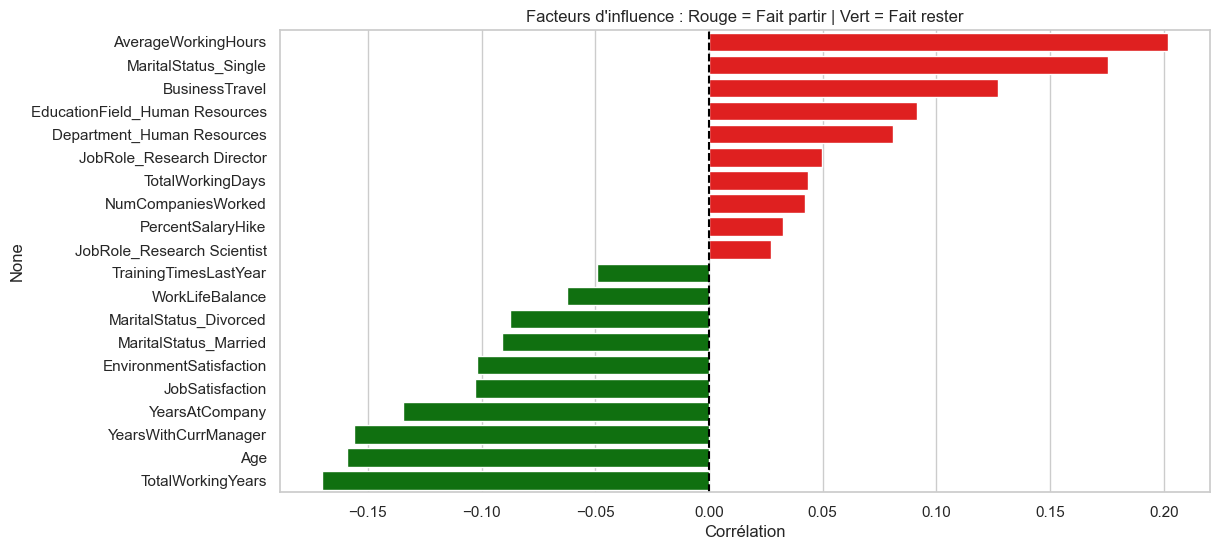

 Préparation des données (Train/Test Split)...
   Train set : 3087 employés
   Test set  : 1323 employés

 Début de l'entraînement des modèles...
------------------------------------------------------------
   🔹 LogisticRegression   | Recall Test: 0.244 | CV Recall Moy: 0.235
   🔹 Perceptron           | Recall Test: 0.127 | CV Recall Moy: 0.394
   🔹 SVM                  | Recall Test: 0.338 | CV Recall Moy: 0.335
   🔹 KNN                  | Recall Test: 0.300 | CV Recall Moy: 0.313
   🔹 NaiveBayes           | Recall Test: 0.366 | CV Recall Moy: 0.372
   🔹 DecisionTree         | Recall Test: 0.892 | CV Recall Moy: 0.805
   🔹 RandomForest         | Recall Test: 0.911 | CV Recall Moy: 0.811
   🔹 XGBoost              | Recall Test: 0.934 | CV Recall Moy: 0.859
   🔹 ReseauNeuronal       | Recall Test: 0.920 | CV Recall Moy: 0.872

 CLASSEMENT FINAL (Trié par Recall & F1-Score) :


,Modèle,Accuracy,Precision,Recall,CV Recall Moyen,CV Ecart-Type,F1-Score,AUC,Temps (s)
7,XGBoost,0.983371,0.961353,0.934272,0.859495,0.035076,0.947619,0.980227,1.924617
8,ReseauNeuronal,0.984883,0.984925,0.920188,0.871556,0.030989,0.951456,0.980053,26.583771
6,RandomForest,0.983371,0.984772,0.910798,0.811313,0.048218,0.946341,0.987296,1.927692
5,DecisionTree,0.968254,0.909091,0.892019,0.805212,0.023589,0.900474,0.937451,0.153997
4,NaiveBayes,0.832200,0.472727,0.366197,0.371556,0.022147,0.412698,0.755623,0.036512
2,SVM,0.885110,0.867470,0.338028,0.335394,0.062510,0.486486,0.898401,4.969984
3,KNN,0.833711,0.474074,0.300469,0.313273,0.033857,0.367816,0.868090,1.661573
0,LogisticRegression,0.853364,0.611765,0.244131,0.234828,0.027907,0.348993,0.801011,0.107864
1,Perceptron,0.840514,0.519231,0.126761,0.393677,0.189492,0.203774,0.000000,0.056344



 Génération des matrices de confusion...


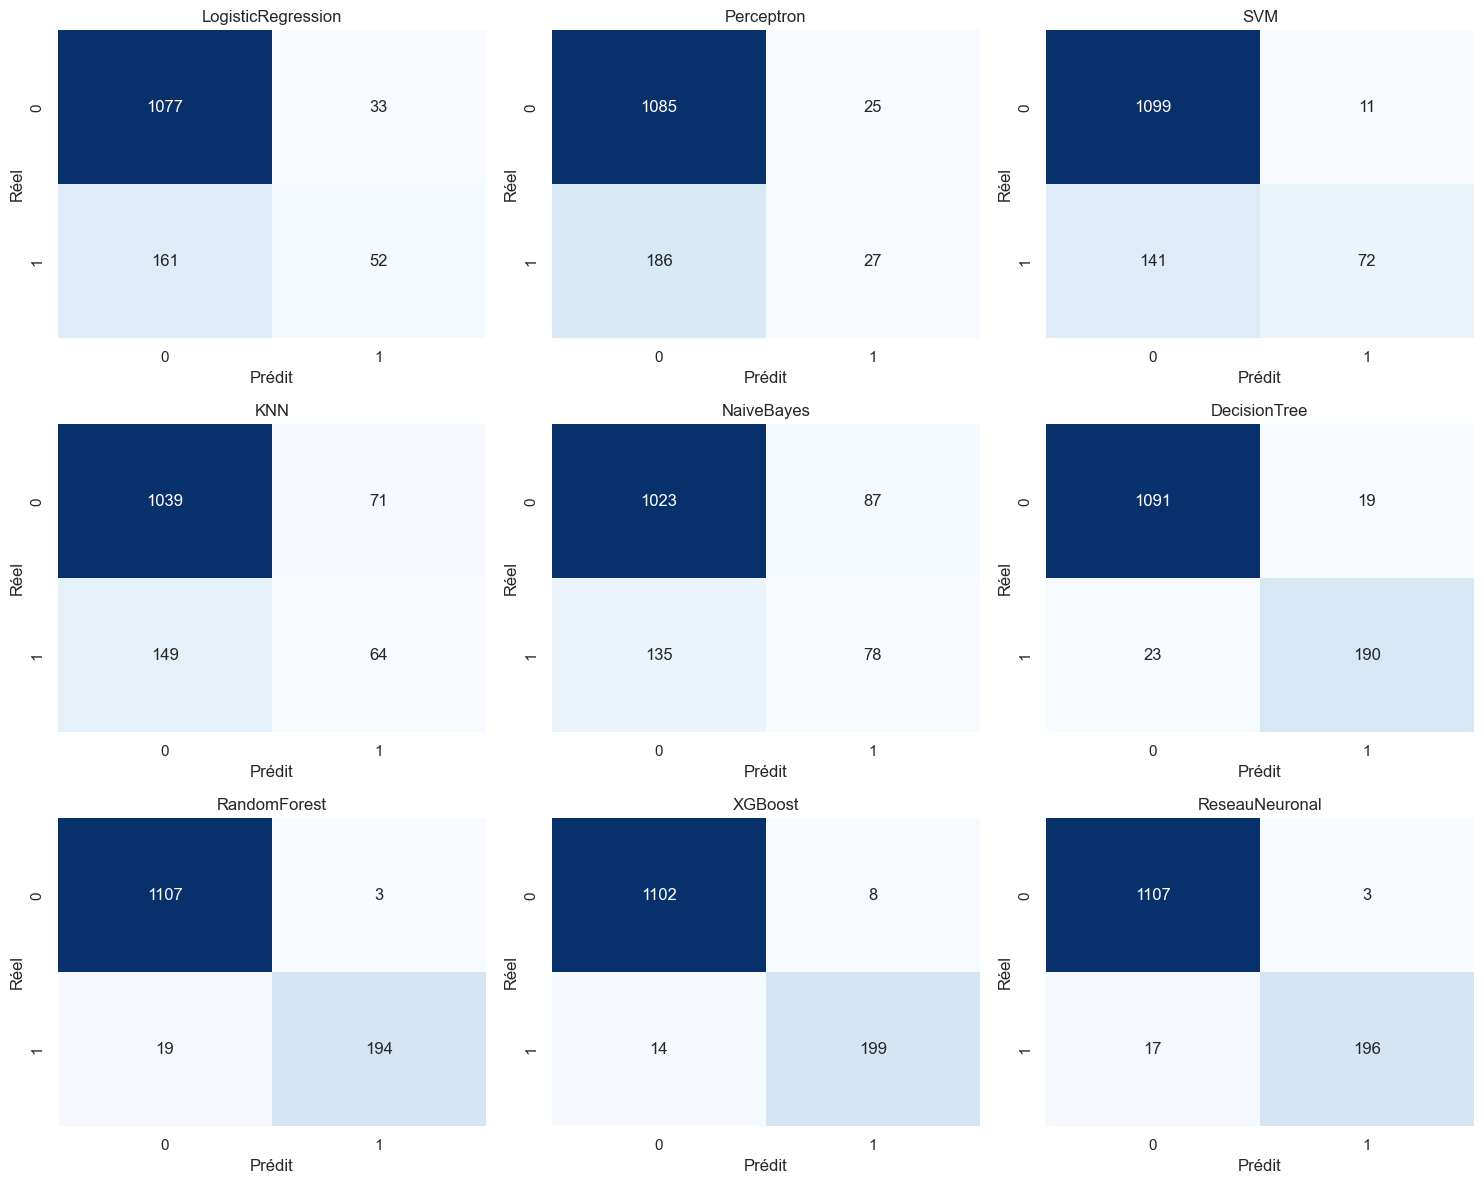


 Analyse des causes réelles du départ (Basé sur : XGBoost)...


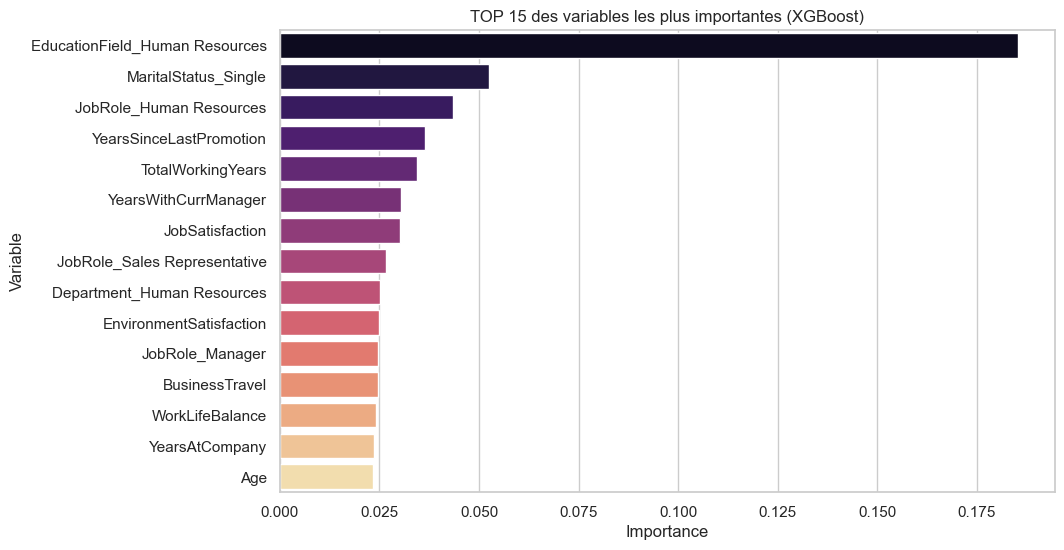

In [6]:
# 1. Chemin du fichier
fichier_csv = 'data/processed_hr_data_encoded_normalized.csv'

# 2. Chargement
df = charger_donnees(fichier_csv)

if df is not None:
    # 3. Analyse  de Corrélation
    analyser_facteurs_influents(df)

    # 4. Préparation
    X_train, X_test, y_train, y_test, feature_names = preparation_donnees(df)
    
    # 5. Entraînement
    resultats_df, modeles_entraines = entrainer_modeles(X_train, X_test, y_train, y_test)
    
    # 6. Tableau des résultats
    print("\n CLASSEMENT FINAL (Trié par Recall & F1-Score) :")
    display(resultats_df.sort_values(by=['Recall', 'F1-Score'], ascending=False))
    
    # 7. Graphiques
    afficher_matrice_confusion(y_test, modeles_entraines, X_test)
    afficher_importance_variables(modeles_entraines, feature_names)